In [2]:
# Manage warning messages

import os, warnings
warnings.filterwarnings('ignore')

In [22]:
# Import necessary libraries

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
# Download stock data as described in 5.1

df = yf.download('JPM', start='1980-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Make df stationary: Apply log and differencing

df['ts_log'] = np.log(df['Close'])
df['ts_log_diff'] = df['ts_log'] - df['ts_log'].shift(1)
df.dropna(inplace=True)

In [6]:
# Define the training set as the differenced log series

train = df['ts_log_diff']

In [7]:
# Calculate the autocorrelation function (ACF) and partial autocorrelation function (PACF) for model identification

lag_acf = acf(train, nlags = 20)
lag_pacf = pacf(train, nlags = 20)


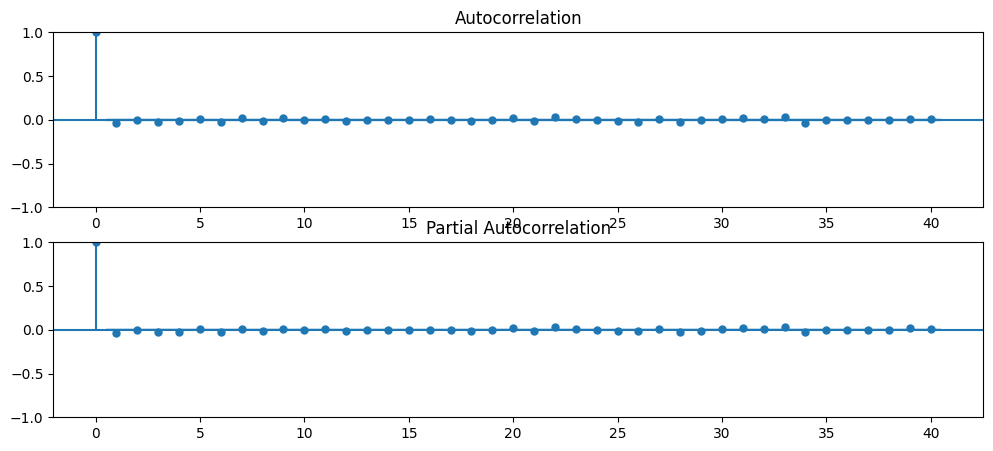

In [9]:
# Plot ACF and PACF to visualize autocorrelation

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.dropna(),lags=40, ax=ax2)


In [10]:
# Fit the ARIMA model to the training data

model_arima = ARIMA(train, order=(1, 2, 1))
model_fit_arima = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# Forecast 3 future values using the fitted ARIMA model

next = 3
forecast_arima = model_fit_arima.forecast(steps=next)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
# Transform the forecasted log prices back to the original scale

predicted_stock_prices_forecast_arima = pd.Series(df['ts_log'].iloc[-1], index=forecast_arima.index).add(forecast_arima.cumsum(), fill_value=0)
predicted_stock_prices_forecast_arima = np.exp(predicted_stock_prices_forecast_arima)

In [13]:
# Download actual stock prices for comparison

actual_df_arima = yf.download('JPM', start='2024-01-02', end='2024-01-05')
actual_stock_prices_arima = actual_df_arima['Close']

[*********************100%%**********************]  1 of 1 completed


In [14]:
predicted_stock_prices_forecast_arima.values # display the predictions

array([170.46642711, 170.54196774, 170.76750593])

In [25]:
actual_stock_prices_arima

,Close
Date,
2024-01-02,172.080002
2024-01-03,171.330002
2024-01-04,171.410004


In [15]:
# Create a series for the predicted stock prices

predicted_stock_prices_arima = pd.Series(predicted_stock_prices_forecast_arima.values, index=actual_stock_prices_arima.index[:len(predicted_stock_prices_forecast_arima)+1])

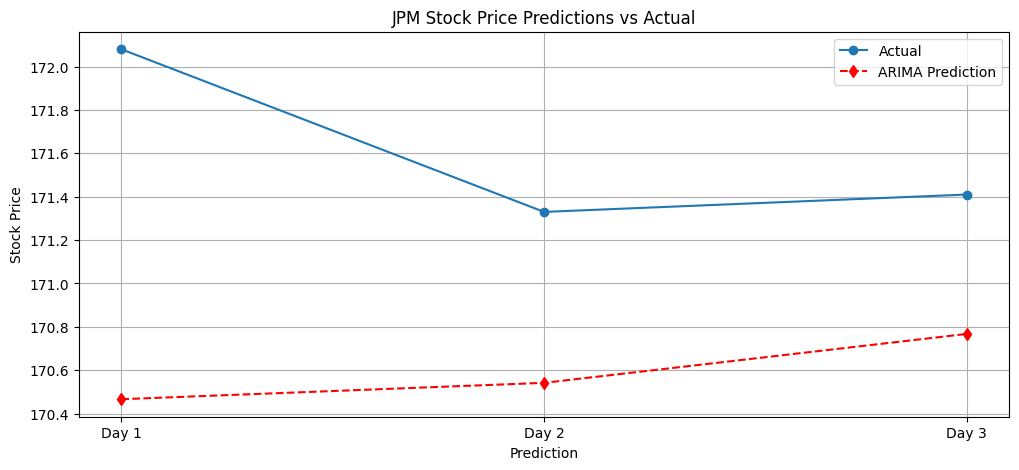

In [20]:
# Plot the forecasted prices against the actual prices

days = ["Day 1", "Day 2", "Day 3"]
actual = actual_stock_prices_arima
arima_prediction = predicted_stock_prices_arima

plt.figure(figsize=(12, 5))

plt.plot(days, actual, marker='o', label='Actual', linestyle='-')
plt.plot(days, arima_prediction, marker='d', color='red', label='ARIMA Prediction', linestyle='--')

plt.title('JPM Stock Price Predictions vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()